In [3]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

# As an alternative, if you'd like to use Ollama instead of OpenAI
# Check that Ollama is running for you locally (see week1/day2 exercise) then uncomment these next 2 lines
# MODEL = "llama3.2"
# openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')


OpenAI API Key exists and begins sk-proj-


In [5]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [6]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


Tools

Tools are incredibly powerful feature provided by LLMs. With tools, you can create a function and have the LLM function call that function as a part of it's response. Sounds almost spooky - we're giving it power to run code in our machine.

In [7]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [8]:
get_ticket_price("london")

Tool get_ticket_price called for london


'$799'

In [9]:
# build a particular dictionary structure that describes our function


price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [10]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

Getting OpenAI to use our tool

There's some fiddly stuff to allow OpenAI to "call our tool"

Here's how the new chat function looks.

In [11]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [12]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [13]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.


Let's go Multi Modal !!!

We can use DALL-E, the image creation model behind GPT-4O, to make us some images

Let's put this in a function called artist.

Price alert - each time I create an image, it costs about 4 C

In [14]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [15]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [16]:
#image = artist("Philadelphia")
#display(image)

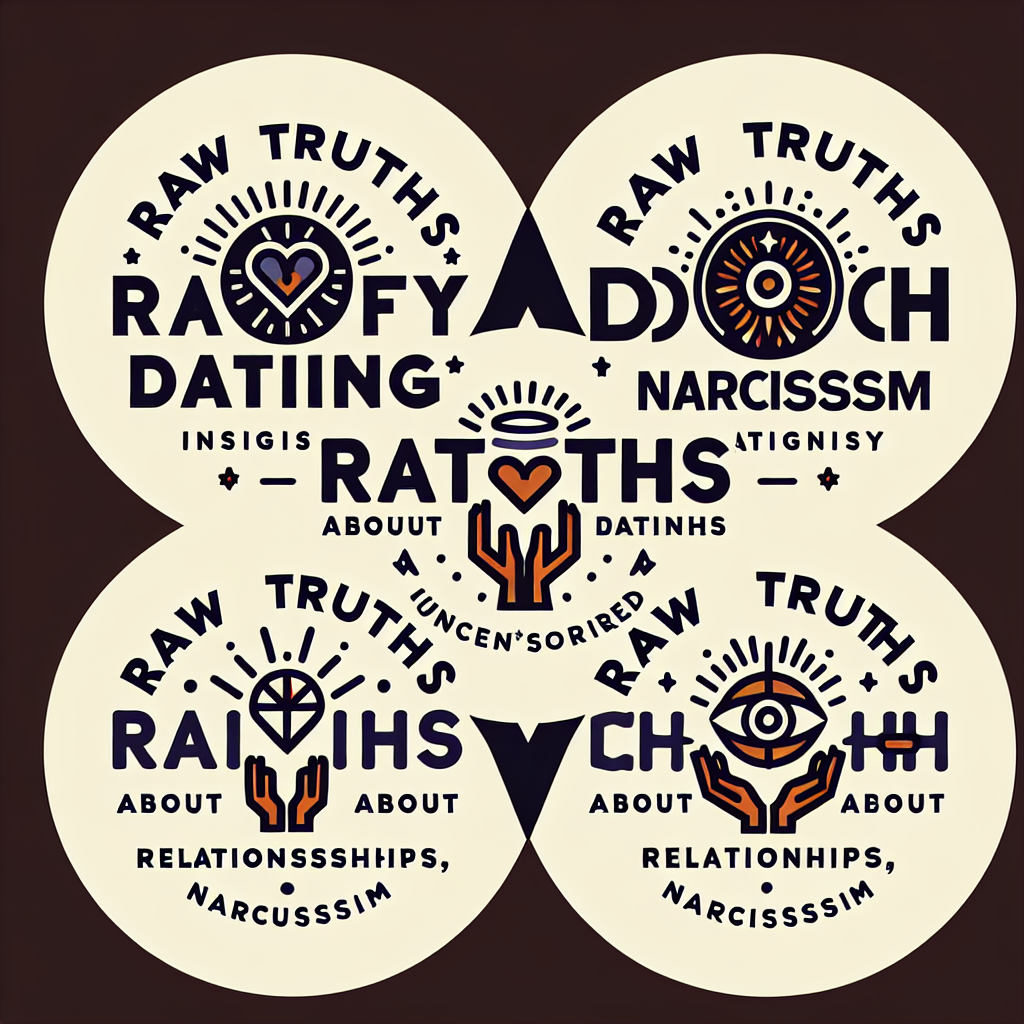

In [23]:
def create_logo():
    logo_response = openai.images.generate(
        model="dall-e-3",
        prompt="A logo design for a brand that shares RAW content about relationships, dating, and narcissism, emphasizing safety and awareness. The logo should be modern, clean, and professional. The design should convey trust, safety, and awareness. I need a palette of 5 logos. It should contains these words RAW truths about relationships, dating, and narcissism",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    logo_base64 = logo_response.data[0].b64_json
    logo_data = base64.b64decode(logo_base64)
    return Image.open(BytesIO(logo_data))

logo_image = create_logo()
display(logo_image)

Audio

Let's write a function that uses ChatGPT to generate audio

In [29]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
built with Apple clang version 16.0.0 (clang-1600.0.26.6)
configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [27]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="alloy",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [30]:
talker("Well, hi there! I'm your assistant, and I'm here to help you with all your travel needs. Just ask me anything about flights, destinations, or travel tips, and I'll do my best to assist you. Let's make your travel experience amazing!")

Input #0, wav, from '/var/folders/s_/0654r6ss3690j6l79b4rwvfh0000gn/T/tmparfgegt2.wav':
  Duration: 00:00:13.97, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as

1. Break a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks.
2. The ability of LLMs to use tools to give them additional capabilities.
3. The Agent environment which allows agents to colloborate.
4. The LLM can act as the planner, dividing bigger tasks into smaller ones for the specialists.
5. The concept of agent having autonomy/agency beyond just responding to the prompt - such as memory.

In [31]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [32]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/s_/0654r6ss3690j6l79b4rwvfh0000gn/T/tmpzseai1mr.wav':
  Duration: 00:00:02.06, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/s_/0654r6ss3690j6l79b4rwvfh0000gn/T/tmpggzer2rn.wav':
  Duration: 00:00:03.17, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for London


Input #0, wav, from '/var/folders/s_/0654r6ss3690j6l79b4rwvfh0000gn/T/tmpg5oygn81.wav':
  Duration: 00:00:02.95, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
